# Autoencoder for PETALO

Esta red la vamos a utilizar para comprimir los datos

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from keras import regularizers
from math import floor
#from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de petalo preprocesados en matlab


In [2]:
import scipy.io as sio
import hdf5storage
datos_matlab = hdf5storage.loadmat('../datos_julio_2018/conjunto_entrenamiento_julio_2018_ring1y2_total.mat')
conjunto_datos= datos_matlab.get('photodefbox2_todo')
conjunto_datos.shape

(100000, 5788)

## Network parameters:

In [3]:
# empezamos con el autoencoder A de dimensión 480-240-480 (30 columnas x 16 filas de sensores )
datos_matlab= hdf5storage.loadmat('../redes_compresoras/resultadoscompresores_def_1_medio_export.mat')
encoder_weights_A= datos_matlab.get('encoder_weights_A')
encoder_biases_A= datos_matlab.get('encoder_biases_A')
decoder_weights_A= datos_matlab.get('decoder_weights_A')
decoder_biases_A= datos_matlab.get('decoder_biases_A')
min_A=datos_matlab.get('minA')
max_A=datos_matlab.get('maxA')
Encoder_weights_A=encoder_weights_A.transpose()
Encoder_biases_A=encoder_biases_A.transpose()[0]
Decoder_weights_A=decoder_weights_A.transpose()
Decoder_biases_A=decoder_biases_A.transpose()[0]

# empezamos con el autoencoder B de dimensión 448-240-480 (28 columnas x 16 filas de sensores )
encoder_weights_B= datos_matlab.get('encoder_weights_B')
encoder_biases_B= datos_matlab.get('encoder_biases_B')
decoder_weights_B= datos_matlab.get('decoder_weights_B')
decoder_biases_B= datos_matlab.get('decoder_biases_B')
min_B=datos_matlab.get('minB')
max_B=datos_matlab.get('maxB')
Encoder_weights_B=encoder_weights_B.transpose()
Encoder_biases_B=encoder_biases_B.transpose()[0]
Decoder_weights_B=decoder_weights_B.transpose()
Decoder_biases_B=decoder_biases_B.transpose()[0]

#Encoder_biases[0]

Vamos a crear lod dos autoencoders compresores como modelos Keras

In [4]:
    
encoding_dim = 240  # floats -> compression of factor 2, assuming the input is 480 floats

# input image dimensions = sensor dimensions
img_rows, img_cols = 16, 30
input_output_dim_A=img_rows*img_cols
# this is our input placeholder
input_img_A = Input(shape=(input_output_dim_A,))
# "encoded" is the encoded representation of the input
encoded_A = Dense(encoding_dim, activation='sigmoid',use_bias=True, weights=[Encoder_weights_A,Encoder_biases_A] )(input_img_A)
# "decoded" is the lossy reconstruction of the input
decoded_A = Dense(input_output_dim_A, activation='sigmoid',use_bias=True, weights=[Decoder_weights_A,Decoder_biases_A] )(encoded_A)

# this model maps an input to its reconstruction
autoencoder_matlab_A = Model(input_img_A, decoded_A)
# autoencoder_matlab.get_weights()

In [5]:


# input image dimensions = sensor dimensions
img_rows, img_cols = 16, 28
input_output_dim_B=img_rows*img_cols
# this is our input placeholder
input_img_B = Input(shape=(input_output_dim_B,))
# "encoded" is the encoded representation of the input
encoded_B = Dense(encoding_dim, activation='sigmoid',use_bias=True, weights=[Encoder_weights_B,Encoder_biases_B] )(input_img_B)
# "decoded" is the lossy reconstruction of the input
decoded_B = Dense(input_output_dim_B, activation='sigmoid',use_bias=True, weights=[Decoder_weights_B,Decoder_biases_B] )(encoded_B)

# this model maps an input to its reconstruction


autoencoder_matlab_B = Model(input_img_B, decoded_B)

## Prepare data into training and test set.

In [6]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=5
val_size=90
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


X_train=conjunto_datos[:tamanyo_tr,:]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,:]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]


100000
conjunto_datos shape: (100000, 5788)
5000
90000
5000


Vamos a generar las matrices de datos para la red neuronal 

In [7]:
x_train = X_train
x_test = X_test
print(x_train.shape)
print(x_test.shape)
print(x_test.shape[0])

(5000, 5788)
(5000, 5788)
5000


# Vamos a procesar y comprimir con las dos redes

Primero escalamos los datos

In [8]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
# min_max_scaler = preprocessing.RobustScaler().fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)

min_max_scaler_A = preprocessing.MinMaxScaler().fit(x_train[:,6:6+4*input_output_dim_A])
min_max_scaler_B = preprocessing.MinMaxScaler().fit(x_train[:,6+4*input_output_dim_A:6+4*input_output_dim_A+3*input_output_dim_B])
x_test_scaled = min_max_scaler.transform(x_test)


min_max_scaler_A.data_max_.shape

(1920,)

Ahora los particionamos y pasamos por las redes de compresión. Hay una red la A que se utiliza 4 veces
y otra red la B que se utiliza 3 veces

In [27]:
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((4,input_output_dim_A))
ideaB=np.zeros((3,input_output_dim_B)) 
cara_externa=x_test[:,6:6+4*input_output_dim_A+3*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_test.shape[0],4*input_output_dim_A+3*input_output_dim_B))
for i in range(x_test.shape[0]):
    for k in range(4):
        ideaA[k,:]=x_test[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
    encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
    decoded_imgs_A= sigmoid(np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
    #print(decoded_imgs_A.shape)
    salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
    for k in range(3):
        ideaB[k,:input_output_dim_B]=x_test[i,6+4*input_output_dim_A+k*input_output_dim_B:6+4*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
    encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
    decoded_imgs_B= sigmoid(np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
    salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose(); 
    hola1=np.reshape(salida_reconstructed_1,(1920))
    hola2=np.reshape(salida_reconstructed_2,(1344))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total

In [1]:
n = 1  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(204, 16).transpose(),vmin=0, vmax=10)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(204, 16).transpose(), vmin=0, vmax=10)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

NameError: name 'plt' is not defined

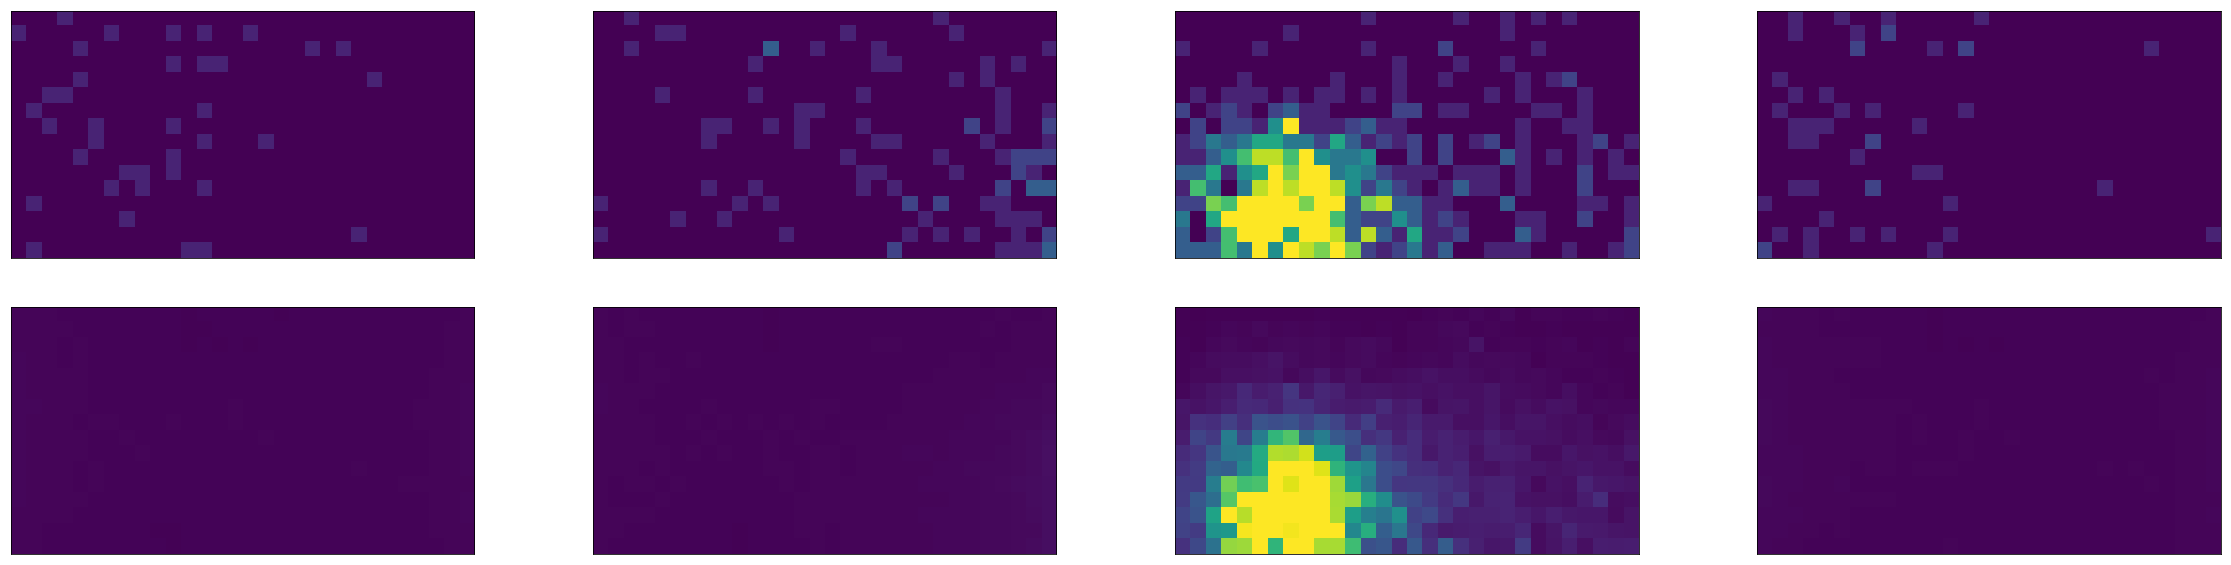

In [29]:
n = 4  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(204, 16).transpose()[:,i*30:(i+1)*30] ,vmin=0, vmax=10)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(204, 16).transpose()[:,i*30:(i+1)*30] ,vmin=0, vmax=10)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

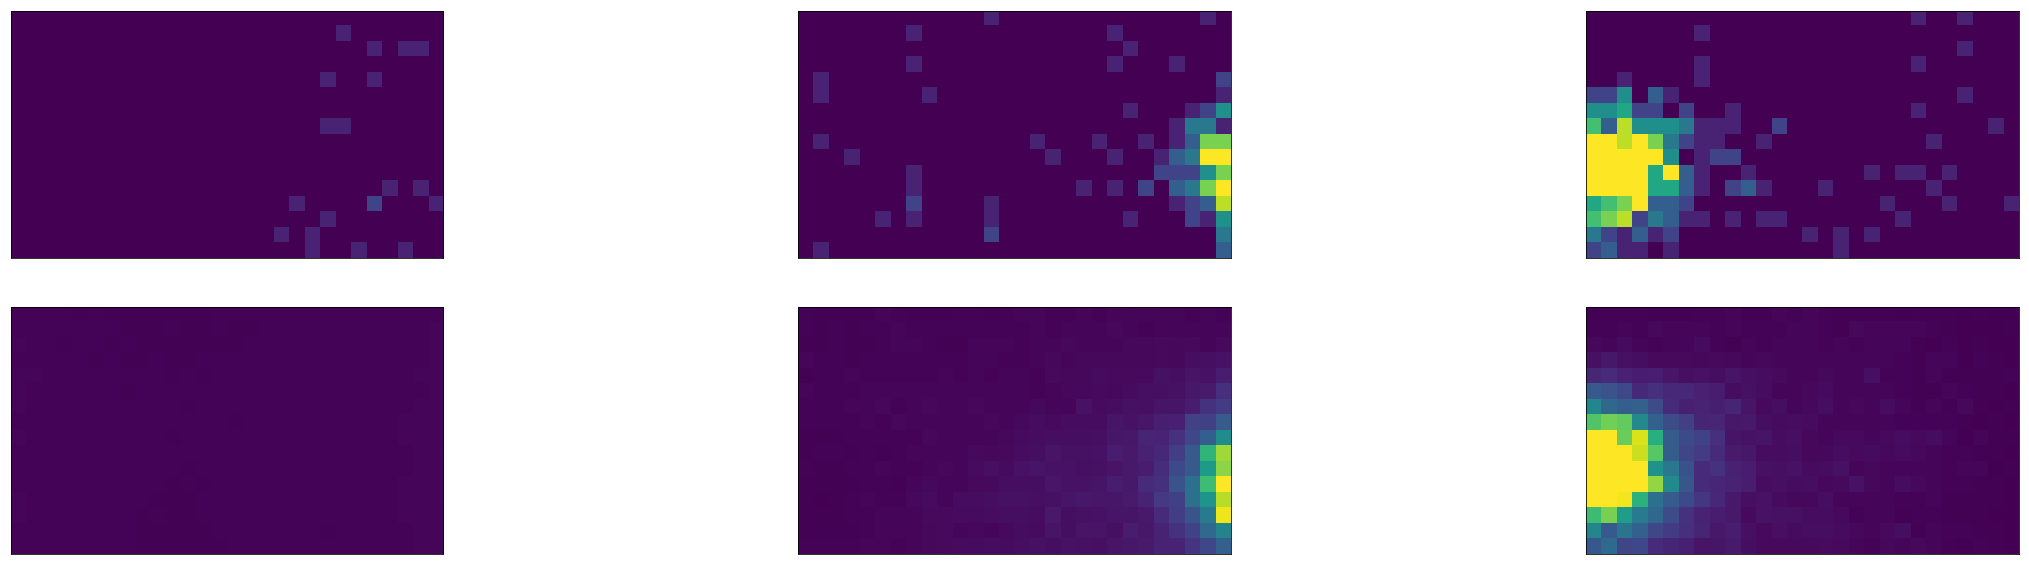

590


In [30]:
n = 3  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(204, 16).transpose()[:,120+i*28:120+(i+1)*28],vmin=0, vmax=10)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(204, 16).transpose()[:,120+i*28:120+(i+1)*28],vmin=0, vmax=10)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)

In [33]:
print(np.amax(cara_externa[idea].reshape(204,16),axis=1)[120:])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  1.  1.  1.  1.  1.  2.  1.  1.  1.  1.  0.  1.  0.  1.  0.  1.  0.  2.
  1.  0.  0.  0.  2.  0.  0.  1.  1.  0.  1.  1.  1.  1.  2.  2.  3.  4.
 13. 14. 26. 22. 22. 17. 12. 11.  4.  1.  2.  2.  3.  1.  2.  0.  1.  1.
  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.]


In [32]:
print(np.amax(cara_externa_reconstruida[idea].reshape(204,16),axis=1)[120:])

[ 0.14077662  0.12091877  0.10858423  0.1028131   0.10157878  0.10848308
  0.09673712  0.09299702  0.08938248  0.09506753  0.08851132  0.09492932
  0.08907158  0.09175534  0.09548441  0.0966905   0.0997321   0.09952288
  0.09852084  0.10280615  0.10765817  0.10619091  0.11538711  0.11523666
  0.11277145  0.12269562  0.13871846  0.16094598  0.16306736  0.11424655
  0.11193796  0.15172635  0.19226674  0.19546686  0.21308811  0.22390975
  0.27409156  0.25549137  0.33720019  0.34361703  0.40002511  0.44267531
  0.49267949  0.55894498  0.66678653  0.57775471  0.65336699  0.60409403
  0.8001937   0.78563202  1.18395669  1.69724936  2.61418562  3.71080861
  6.90081095 12.47985477 25.90365198 19.49834706 20.90559644 13.55421562
  8.39264794  4.7795949   2.68322317  1.98677428  1.47232327  1.02028656
  0.76414137  0.56560456  0.43985983  0.47553642  0.38277888  0.37393126
  0.44975285  0.49927059  0.408863    0.34968294  0.37929396  0.25408948
  0.32749637  0.18925185  0.22245139  0.17066601  0